In [ ]:
#https://drive.google.com/file/d/1JRBsU8r20_EVoK0I4zVFB5PM_8TgLpJ/view?usp=sharing
!gdown 1JRBsU8r20_EVoK0I4z-VFB5PM_8TgLpJ

import zipfile 
zip_ref = zipfile.ZipFile("/content/archive.zip", 'r') 
zip_ref.extractall("/content/tmp")
zip_ref.close() 

Downloading...
From: https://drive.google.com/uc?id=1JRBsU8r20_EVoK0I4z-VFB5PM_8TgLpJ
To: /content/archive.zip
100% 129M/129M [00:00<00:00, 359MB/s]


In [ ]:
!pip install split-folders 
import os 
import cv2 
import pathlib
import numpy as np 
import pandas as pd 
import splitfolders 
from tqdm import tqdm 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import matplotlib.patches as patches 
from keras.models import model_from_json 
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam 
from sklearn.preprocessing import LabelEncoder 
from tensorflow.keras.utils import to_categorical 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
from tensorflow.keras.layers import Dropout, BatchNormalization, Input, Dense, Flatten, Conv2D
import warnings
%matplotlib inline 
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


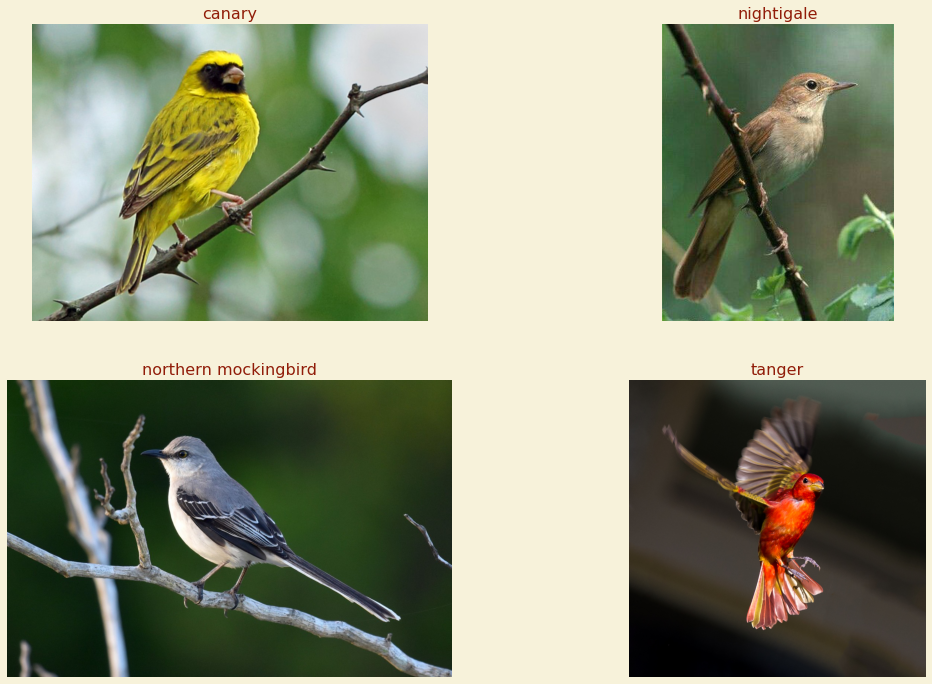

In [ ]:
canary = load_img("/content/tmp/archive/Canary/900.jpeg.jpg") 
nightingale = load_img("/content/tmp/archive/Nightingale/0020bcd13ced69578e2c6e031cafb925.jpg")
northern_mockingbird = load_img("/content/tmp/archive/Nothern Mockingbird/1200.jpeg.jpg")
tanager = load_img("/content/tmp/archive/Tanager/1295367.jpg") 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12)) 
ax1.imshow(canary) 
ax1.axis("off") 
ax1.set_title("canary", fontdict={"fontsize":16, "color":"#911d09"}) 
ax2.imshow(nightingale)
ax2.axis("off") 
ax2.set_title("nightigale", fontdict={"fontsize":16, "color":"#911d09"})
ax3.imshow(northern_mockingbird)
ax3.axis("off")
ax3.set_title("northern mockingbird", fontdict={"fontsize":16,"color":"#911d09"})
ax4.imshow(tanager) 
ax4.axis("off") 
ax4.set_title("tanger", fontdict={"fontsize":16, "color":"#911d09"}) 
ax = fig.add_axes([0.41,0.38,0.26,0.26]) #[left, bottom, width, height] 
ax.axis("off") 
fig.patch.set_facecolor("#f7f2da") 
plt.show()

In [ ]:
data_bs = pathlib.Path("/content/tmp/archive/") 
splitfolders.ratio(data_bs, output="Imgs/", ratio=(0.9, 0.1), group_prefix=None)

Copying files: 602 files [00:00, 1545.14 files/s]


In [ ]:
# configure augmentation
ds = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=5,
                                                  width_shift_range=0.1, 
                                                  height_shift_range=0.1, 
                                                  zoom_range=0.1, 
                                                  vertical_flip=True)

data_gen_no_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.5)

# load data 
train_data = ds.flow_from_directory(directory="Imgs/train/",
                                    target_size=(256, 256), 
                                    color_mode="rgb", 
                                    batch_size=32, 
                                    class_mode="sparse") 
validation_data_gen = data_gen_no_augmentation.flow_from_directory(directory="Imgs/val/",
                                          	target_size=(256, 256), 
                                              color_mode="rgb",                       
                                            	batch_size=32, 
                                            	subset="validation", 
                                            	class_mode="sparse")
test_data = data_gen_no_augmentation.flow_from_directory(directory="Imgs/val/",target_size=(256, 256), color_mode="rgb", batch_size=32, subset="training", class_mode="sparse") 


Found 517 images belonging to 4 classes.
Found 30 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


In [ ]:
model_input = Input(shape=(256, 256, 3)) 
resnet_50_v2 = tf.keras.applications.resnet_v2.ResNet50V2( weights="imagenet", input_shape=(256, 256, 3), include_top=False)
for layer in resnet_50_v2.layers:
  if layer.name == "conv5_block3_3_conv": 
    layer.trainable = True 
  else:
    layer.trainable = False
    
x = tf.keras.layers.Rescaling(1.0/255)(model_input)
x = Conv2D(80, (3, 3), padding="same", activation="relu")(resnet_50_v2(x))
x = BatchNormalization()(x) 
x = Dropout(0.3)(x) 
x = Flatten()(x)

x = Dense(1024, activation="relu")(x) 
x = BatchNormalization()(x) 
x = Dropout(0.3)(x) 
x = Dense(512, activation="relu")(x) 
x = BatchNormalization()(x) 
x = Dropout(0.3)(x) 
x = Dense(256, activation="relu")(x) 
x = BatchNormalization()(x) 
x = Dropout(0.3)(x) 
x = Dense(128, activation="relu")(x) 
x = BatchNormalization()(x) 
x = Dropout(0.3)(x) 

model_output = Dense(4, activation="softmax")(x) 

classifier = Model(model_input, model_output)
classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 80)          1474640   
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 80)         320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 8, 8, 80)          0         
                                                             

In [ ]:
opt = Adam(learning_rate=0.001) 
classifier.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics="sparse_categorical_accuracy")
classifier.save_weights("model.h5") 
History = classifier.fit(train_data, epochs=20, validation_data=validation_data_gen)

Epoch 1/20
17/17 [==============================] - 33s 2s/step - loss: 1.6892 - sparse_categorical_accuracy: 0.3888 - val_loss: 5.3250 - val_sparse_categorical_accuracy: 0.2667
Epoch 2/20
17/17 [==============================] - 17s 986ms/step - loss: 1.2148 - sparse_categorical_accuracy: 0.4894 - val_loss: 3.8826 - val_sparse_categorical_accuracy: 0.4000
Epoch 3/20
17/17 [==============================] - 16s 960ms/step - loss: 1.1294 - sparse_categorical_accuracy: 0.5280 - val_loss: 3.0971 - val_sparse_categorical_accuracy: 0.4667
Epoch 4/20
17/17 [==============================] - 16s 959ms/step - loss: 1.0680 - sparse_categorical_accuracy: 0.5261 - val_loss: 2.1605 - val_sparse_categorical_accuracy: 0.6333
Epoch 5/20
17/17 [==============================] - 17s 1s/step - loss: 0.8238 - sparse_categorical_accuracy: 0.6402 - val_loss: 1.7046 - val_sparse_categorical_accuracy: 0.7000
Epoch 6/20
17/17 [==============================] - 16s 961ms/step - loss: 0.8196 - sparse_categorica

In [ ]:
classifier.evaluate(test_data)
History
History.params
History.history.keys()

1/1 [==============================] - 1s 692ms/step - loss: 0.4594 - sparse_categorical_accuracy: 0.8750


dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

In [ ]:
X=[]
Z=[]
IMG_SIZE=256 
BIRD_CANARY_DIR='/content/tmp/archive/Canary'
BIRD_NIGHTINGALE_DIR='/content/tmp/archive/Nightingale'
BIRD_MOCKINGBIRD_DIR='/content/tmp/archive/Nothern Mockingbird'
BIRD_TANAGER_DIR='/content/tmp/archive/Tanager' 

def label_bird(img,bird_type): 
  return bird_type 

def make_train_data(bird_type,DIR): 
  for img in tqdm(os.listdir(DIR)): 
    label=label_bird(img,bird_type ) 
    path = os.path.join(DIR,img) 
    img = cv2.imread(path) 
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) 
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
  X.append(np.array(img)) 
  Z.append(str(label)) 

In [ ]:
make_train_data('Canary',BIRD_CANARY_DIR) 
print(len(X))

100%|██████████| 151/151 [00:02<00:00, 57.07it/s]

1


In [ ]:
make_train_data('Nightingale',BIRD_NIGHTINGALE_DIR)
print(len(X))

100%|██████████| 150/150 [00:01<00:00, 75.50it/s]

2


In [ ]:
make_train_data('Mockingbird',BIRD_MOCKINGBIRD_DIR) 
print(len(X))

100%|██████████| 150/150 [00:03<00:00, 47.72it/s]

3


In [ ]:
make_train_data('Tanager',BIRD_TANAGER_DIR) 
print(len(X))

100%|██████████| 151/151 [00:03<00:00, 43.07it/s]

4


Text(0.5, 1.0, 'Tỷ lệ % các loại chim')

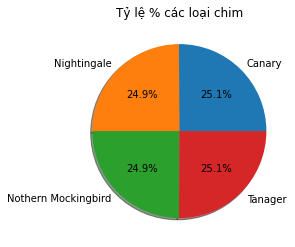

In [ ]:
plt.pie(x = np.array([151, 150, 150,151]), labels = ['Canary', 'Nightingale', 'Nothern Mockingbird','Tanager'], autopct = '%1.1f%%', shadow = True)
plt.title('Tỷ lệ % các loại chim')

In [ ]:
le=LabelEncoder() 
Y=le.fit_transform(Z) 
Y=to_categorical(Y,5) 
X=np.array(X) 
X=X/255 
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

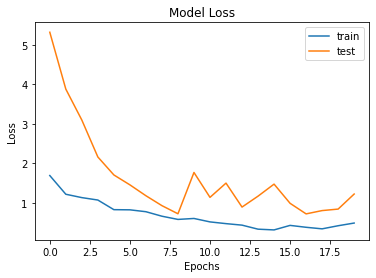

In [ ]:
plt.plot(History.history['loss']) 
plt.plot(History.history['val_loss']) 
plt.title('Model Loss') 
plt.ylabel('Loss') 
plt.xlabel('Epochs') 
plt.legend(['train', 'test']) 
plt.show()

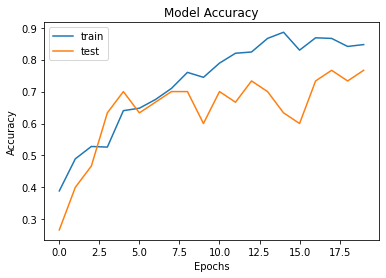

In [ ]:
plt.plot(History.history['sparse_categorical_accuracy'])
plt.plot(History.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy') 
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['train', 'test']) 
plt.show()

In [ ]:
pred=classifier.predict(x_test) 
pred_digits=np.argmax(pred,axis=1)
i=0 
prop_class=[] # True 
mis_class=[] # False 
for i in range(len(y_test)): 
  if(np.argmax(y_test[i])==pred_digits[i]): 
    prop_class.append(i)
  if(len(prop_class)==8):
    break
i=0 
for i in range(len(y_test)): 
  if(not np.argmax(y_test[i])==pred_digits[i]): 
    mis_class.append(i) 
    if(len(mis_class)==8): 
      break

1/1 [==============================] - 2s 2s/step


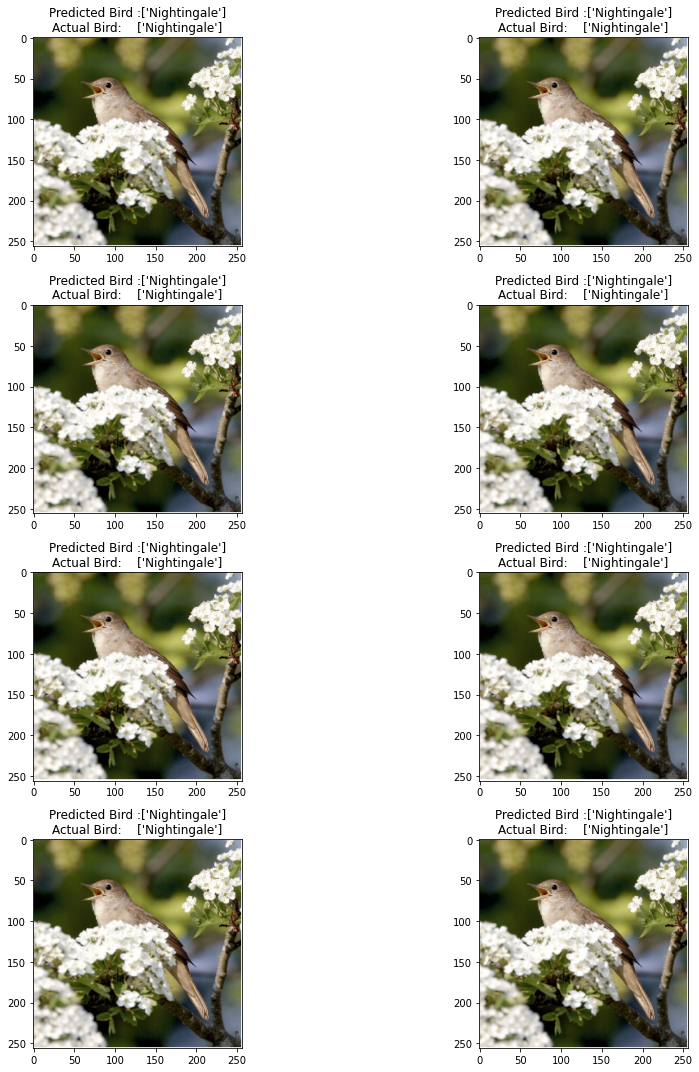

In [ ]:
count=0 
fig,ax=plt.subplots(4,2) 
fig.set_size_inches(15,15) 
for i in range (4):
  for j in range (2):
    ax[i,j].imshow(x_test[prop_class[count]]) 
    ax[i,j].set_title("Predicted Bird :"+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Bird:    "+str(le.inverse_transform([np.argmax(y_test[prop_class[count]])])))
plt.tight_layout()
count+=1

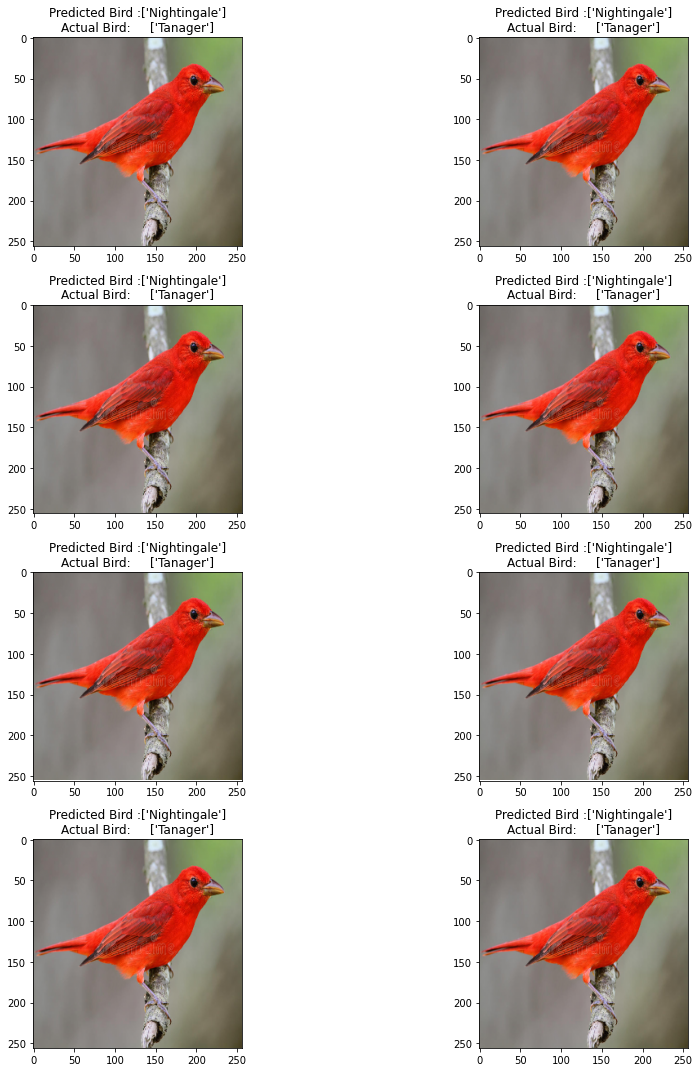

In [ ]:
count=0 
fig,ax=plt.subplots(4,2) 
fig.set_size_inches(15,15) 
for i in range (4): 
  for j in range (2): 
    ax[i,j].imshow(x_test[mis_class[count]]) 
    ax[i,j].set_title("Predicted Bird :"+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Bird:     "+str(le.inverse_transform([np.argmax(y_test[mis_class[count]])])))      
plt.tight_layout() 
count+=1